#### Load the full dataset

In [1]:
import json

f = open('data/full-dataset-v4.json')
fullData = json.load(f)
f.close()

In [ ]:
# This is the standard loop to browse the wristband data trial by trial
for participantId in fullData:
    if participantId != "tracks":
        for session in fullData[participantId]:
            if session != "participant_occupation":
                psEDA = fullData[participantId][session]["wristband"]["EDA"]
                
                # print the last 10 EDA records
                print(psEDA[-10:])

### Correlation between skewness and effort

Spearman
rho: 0.31082788741845446
p-value: 0.0009497149149889026
Pearson
rho: 0.20045428945757748
p-value: 0.035752818614737066


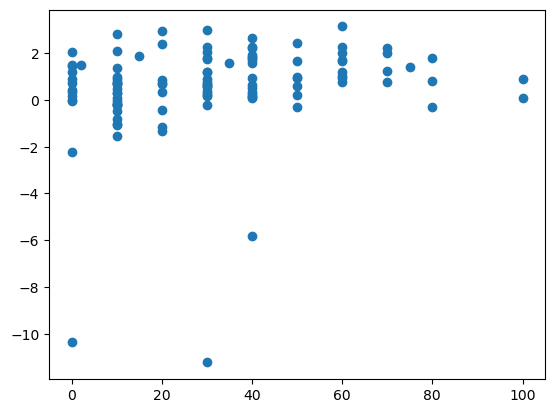

In [2]:
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

samplingRate = 8

data = {
    "Effort": [],
    "Skewness": []
}

# Browse the wristband EDA data trial by trial
for participantId in fullData:
    if participantId != "tracks":
        for session in fullData[participantId]:
            if session != "participant_occupation":
                currentData = fullData[participantId][session]
                psEDA = currentData["wristband"]["EDA"]
                for listening in currentData["post_questionnaires"]:
                    if listening["spotify_id"] is not None:
                        beginning = listening["music_beginning"]
                        end = listening["music_end"] - 10
                        
                        # Fetch the EDA values of the current trial
                        edaValues = []
                        for recording in psEDA:
                            if recording["timestamp"] >= beginning and recording["timestamp"] <= end:
                                edaValues.append(recording["value"])
                        
                        # Some EDA data are missing for some trials, in which case "edaValues" contains 0 values
                        if len(edaValues) > 0:
                            
                            # Resample and process the data
                            resampledValues = nk.signal_resample(edaValues, sampling_rate=4, desired_sampling_rate=samplingRate, method="interpolation")
                            signals, info = nk.eda_process(resampledValues, sampling_rate = samplingRate)

                            if "RSME" in listening:
                                data["Effort"].append(listening["RSME"])
                                data["Skewness"].append(stats.skew(signals["EDA_Phasic"]))

x = data["Effort"]
y = data["Skewness"]

# Compute Spearman correlation
res = stats.spearmanr(x, y)
print("Spearman")
print("rho:", res.statistic)
print("p-value:", res.pvalue)

# Pearson
res = stats.pearsonr(x, y)
print("Pearson")
print("rho:", res.statistic)
print("p-value:", res.pvalue)

# plot it
plt.scatter(x, y)
plt.show()


### Logistic regression

In [5]:
import statsmodels.api as sm
from scipy import stats, integrate
import numpy as np

data = {
    "Effort": [],
    "MeanPhasic": [],
    "MedianPhasic": [],
    "STDPhasic": [],
    "MeanTonic": [],
    "MedianTonic": [],
    "STDTonic": [],
    "NPeaks": [],
    "AUC": [],
    "MaxAmplitudes": [],
    "SumAmplitudes": [],
    "MeanAmplitudes": [],
    "Kurtosis": [],
    "Skewness": [],
    "Zp99": [],
    "SkewnessXzp99": [],
    "SumAmplitudesXNPeaks": []
}

# Browse the wristband EDA data trial by trial
for participantId in fullData:
    if participantId != "tracks":
        for session in fullData[participantId]:
            if session != "participant_occupation":
                currentData = fullData[participantId][session]
                psEDA = currentData["wristband"]["EDA"]
                for listening in currentData["post_questionnaires"]:
                    if listening["spotify_id"] is not None:
                        beginning = listening["music_beginning"]
                        end = listening["music_end"] - 10
                        
                        # Fetch the EDA values of the current trial
                        edaValues = []
                        for recording in psEDA:
                            if recording["timestamp"] >= beginning and recording["timestamp"] <= end:
                                edaValues.append(recording["value"])
                        
                        # Some EDA data are missing for some trials, in which case "edaValues" contains 0 values
                        if len(edaValues) > 0:
                            
                            # Resample and process the data
                            resampledValues = nk.signal_resample(edaValues, sampling_rate=4, desired_sampling_rate=samplingRate, method="interpolation")
                            signals, info = nk.eda_process(resampledValues, sampling_rate = samplingRate)

                            meanPhasic = np.mean(signals["EDA_Phasic"])
                            medianPhasic = np.median(signals["EDA_Phasic"])
                            stdPhasic = np.std(signals["EDA_Phasic"])
                            meanTonic = np.mean(signals["EDA_Tonic"])
                            medianTonic = np.median(signals["EDA_Tonic"])
                            stdTonic = np.std(signals["EDA_Tonic"])
                            npeaks = 0
                            for peak in signals["SCR_Peaks"]:
                                npeaks += peak
                            auc = integrate.trapz(sorted(signals["EDA_Phasic"]), dx=1)
                            maxAmplitudes = max(signals["SCR_Amplitude"])
                            sumAmplitudes = np.nansum(signals["SCR_Amplitude"])
                            meanAmplitudes = np.nanmean(signals["SCR_Amplitude"])
                            kurtosis = stats.kurtosis(signals["EDA_Phasic"])
                            skewness = stats.skew(signals["EDA_Phasic"])
                            zp99 = np.percentile(signals["EDA_Phasic"], 99)
                            skewnessXzp99 = skewness * zp99      
                            sumAmplitudeXNpeaks = sumAmplitudes * npeaks                

                            if "RSME" in listening:
                                data["Effort"].append(listening["RSME"])
                                data["MeanPhasic"].append(meanPhasic)
                                data["MedianPhasic"].append(medianPhasic)
                                data["STDPhasic"].append(stdPhasic)
                                data["MeanTonic"].append(meanTonic)
                                data["MedianTonic"].append(medianTonic)
                                data["STDTonic"].append(stdTonic)
                                data["NPeaks"].append(npeaks)
                                data["AUC"].append(auc)
                                data["MaxAmplitudes"].append(maxAmplitudes)
                                data["SumAmplitudes"].append(sumAmplitudes)
                                data["MeanAmplitudes"].append(meanAmplitudes)
                                data["Kurtosis"].append(kurtosis)
                                data["Skewness"].append(skewness)
                                data["Zp99"].append(zp99)
                                data["SkewnessXzp99"].append(skewnessXzp99)
                                data["SumAmplitudesXNPeaks"].append(sumAmplitudeXNpeaks)

# Assign labels based on the threshold
labels = np.array([1 if effort > 30 else 0 for effort in data["Effort"]])

# Prepare features as a NumPy array
features = np.array([
    # data["MeanPhasic"],
    # data["MedianPhasic"],
    # data["STDPhasic"],
    # data["MeanTonic"],
    # data["MedianTonic"],
    # data["STDTonic"],
    # data["NPeaks"],
    data["AUC"],            ##
    data["MaxAmplitudes"],  ##
    # data["SumAmplitudes"],
    data["MeanAmplitudes"], ##
    # data["Kurtosis"],
    data["Skewness"],       ##
    # data["Zp99"],
    # data["SkewnessXzp99"],
    # data["SumAmplitudesXNPeaks"],
]).T  # Transpose to have samples as rows and features as columns

# Add a constant column for the intercept
features = sm.add_constant(features)

# Perform logistic regression
logit_model = sm.Logit(labels, features)
result = logit_model.fit()

# Print summary including Chi-squared statistic and p-values
print(result.summary())

# Get predicted probabilities
predicted_probabilities = result.predict(features)

# Calculate expected values based on predicted probabilities
expected_values = predicted_probabilities * labels

# Calculate observed frequencies (actual counts of positive class)
observed_frequencies = np.sum(labels)

# Calculate expected frequencies (predicted counts of positive class)
expected_frequencies = np.sum(expected_values)

# Calculate Chi-squared statistic
chi_squared = 2 * (observed_frequencies * np.log(observed_frequencies / expected_frequencies))

# Print the Chi-squared value
print("Chi-squared statistic:", chi_squared)


Optimization terminated successfully.
         Current function value: 0.605944
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  110
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            4
Date:                Sun, 05 Nov 2023   Pseudo R-squ.:                 0.09965
Time:                        07:46:13   Log-Likelihood:                -66.654
converged:                       True   LL-Null:                       -74.031
Covariance Type:            nonrobust   LLR p-value:                  0.005237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6247      0.301     -2.077      0.038      -1.214      -0.035
x1             0.2399      0.